In [ ]:
"""
parameters:
    csv_data:
        mesa, shhs: 'ahi_a0h3'
        mros: 'poahi3'
    max_AHI = 100.
    segment_2d = False
    segment_len = None
    signal_len = 8*3600*1
    batch_size = 64
    epochs = 500
    optimizer = Adam(lr=5e-4)
    scheduler = None
"""

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from torchinfo import summary
from IPython.display import display
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = Path(r'..\dataset\del_wake')
data_json = Path(r'..\dataset\data_list')
mesa_mros_shhs = 'mesa_mros_shhs_20230215.json'
test_dataset1 = 'apnea-ecg-database_20230819.json'
test_dataset2 = '耕莘dataset_20230313.json'
train_name_lst = ['mesa', 'MrOS_visit1', 'MrOS_visit2']

In [3]:
# MESA + MrOS + SHHS
with open(data_json/mesa_mros_shhs) as f:
    all_npz = json.load(f)
# Apnea-ECG-Database
with open(data_json/test_dataset1) as f:
    all_npz[f'apnea_ecg'] = json.load(f)
# 耕莘dataset
with open(data_json/test_dataset2, encoding='utf-8') as f:
    all_npz['耕莘dataset'] = json.load(f)
    
data_num = [[len(i) for i in v.values()] for v in all_npz.values()]
df = pd.DataFrame(data_num).transpose()
df.index = ['normal', 'mild', 'moderate', 'severe']
df.columns = all_npz.keys()
df.loc['total'] = df.sum(axis=0)
df.loc[:, 'total'] = df.sum(axis=1)
df

,mesa,MrOS_visit1,MrOS_visit2,shhs1,shhs2,apnea_ecg,耕莘dataset,total
normal,414,502,154,1766,629,4,45,3514
mild,643,1029,360,2031,960,0,77,5100
moderate,518,792,283,1237,637,0,61,3528
severe,481,583,229,759,425,4,162,2643
total,2056,2906,1026,5793,2651,8,345,14785


In [4]:
train_list = []
test_list = {k: [] for k in all_npz.keys() if k not in train_name_lst}

for k, v in all_npz.items():
    if k in train_name_lst:
        for i in v.values():
            train_list += i
    else:
        for j in v.values():
            test_list[k] += j

print(f'train list: \n\t{len(train_list)}')
print('test list:')
for k, v in test_list.items():
    print(f'\t{k}: {len(v)}')

train list: 
	5988
test list:
	shhs1: 5793
	shhs2: 2651
	apnea_ecg: 8
	耕莘dataset: 345


In [5]:
max_AHI = 100.
SR = 1 # sample rate
segment_2d = False # segment signal to 2D
segment_len = 60*SR if segment_2d else None # length of each segment
signal_len = (8*3600*SR)//segment_len if segment_2d else 8*3600*SR # length of signal

def normalize(signal):
    return signal/100.

def AHI_norm(AHI):
    if AHI > max_AHI:
        return 1.
    else:
        return AHI/max_AHI

def AHI_class(AHI, classes=4, cutoff=15):
    if classes == 2:
        if AHI < cutoff:
            label = 0
        else:
            label = 1
    elif classes == 4:
        if AHI < 5:
            label = 0
        elif 5 <= AHI < 15:
            label = 1
        elif 15 <= AHI < 30:
            label = 2
        else: label = 3
    
    return label

def read_npz_file(file):
    npz_data = np.load(file, allow_pickle=True)
    signal = normalize(npz_data['SpO2'])
    
    if segment_2d:
        segment_num = len(signal)//segment_len
        signal = signal[:segment_num*segment_len].reshape((segment_num, segment_len))
        
    if 'mros' in file:
        label = AHI_norm(float(npz_data['csv_data'].item()['poahi3']))
    elif 'apnea' in file or '耕莘' in file:
        label = AHI_norm(npz_data['AHI'])
    else:
        label = AHI_norm(float(npz_data['csv_data'].item()['ahi_a0h3']))
        
    return signal, label

def cut_pad_signal(signal, length=signal_len, mode='middle'):
    if len(signal) > length:
        cut_len = len(signal)-length
        if mode == 'middle': # cut from middle
            mid = cut_len//2
            return signal[mid:mid+length]
        elif mode == 'random': # random cut
            rand = np.random.randint(cut_len)
            return signal[rand:rand+length]
    else:
        pad_len = length-len(signal)
        if segment_2d:
            signal = np.pad(signal, ((0, pad_len), (0, 0)))
        else:
            signal = np.pad(signal, (0, pad_len))
        return signal

In [6]:
train_info = {i: [] for i in ['signal', 'label']}
test_info = {j: {i: [] for i in ['signal', 'label']} for j in test_list.keys()}

for file in tqdm(train_list):
    path = str(data_dir/file)
    signal, label = read_npz_file(path)
    train_info['signal'].append(signal)
    train_info['label'].append(label)

for k, v in test_list.items():
    for file in tqdm(v):
        path = str(data_dir/file)
        signal, label = read_npz_file(path)
        test_info[k]['signal'].append(signal)
        test_info[k]['label'].append(label)

100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 91.57it/s]


In [9]:
# set model name
time_stamp = datetime.now().strftime('_%Y%m%d_%H%M%S')
model_name = 'm204_ReLU2'+time_stamp

In [6]:
# for reload model
model_name = 'm204_ReLU2_20230302_150035'

In [7]:
from models import m204_ReLU2
model = m204_ReLU2().cuda()
print(model_name)

logs_tb_dir = Path('logs_tb', model_name)
logs_tb_dir.mkdir(parents=True, exist_ok=True)
logs_json_dir = Path('logs_json', model_name)
logs_json_dir.mkdir(parents=True, exist_ok=True)
weights_dir = Path('weights', model_name)
weights_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path('results', model_name)
results_dir.mkdir(parents=True, exist_ok=True)

m204_ReLU2_20230302_150035


In [7]:
class TrainingDataset(Dataset):
    def __init__(self, data_type, signal, label):
        self.data_type = data_type
        self.signal = signal
        self.label = label
        
    def __getitem__(self, index):
        if self.data_type == 'train':
            signal = cut_pad_signal(self.signal[index], mode='random') # fixed length, random cut
        elif self.data_type == 'test':
            signal = cut_pad_signal(self.signal[index]) # fixed length
            
        signal = torch.tensor(signal, dtype=torch.float32).cuda().unsqueeze(0) # [channel, row]
        label = torch.tensor(self.label[index], dtype=torch.float32).cuda().unsqueeze(0)
        return signal, label
    
    def __len__(self):
        return len(self.signal)

In [8]:
batch_size = 64
train_data = DataLoader(TrainingDataset('train', train_info['signal'], train_info['label']),
                        batch_size=batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(TrainingDataset('test', test_info['shhs1']['signal'], test_info['shhs1']['label']),
                       batch_size=batch_size)

In [11]:
# show model summary
model_input, _ = train_data.dataset[0]
summary(model, model_input.unsqueeze(0).size())

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 1]                    --
├─Sequential: 1-1                        [1, 16, 1199]             --
│    └─Sequential: 2-1                   [1, 16, 4799]             --
│    │    └─Conv1d: 3-1                  [1, 16, 4799]             192
│    │    └─ReLU: 3-2                    [1, 16, 4799]             --
│    └─Sequential: 2-2                   [1, 16, 2399]             --
│    │    └─Conv1d: 3-3                  [1, 16, 2399]             784
│    │    └─ReLU: 3-4                    [1, 16, 2399]             --
│    └─Sequential: 2-3                   [1, 16, 1199]             --
│    │    └─Conv1d: 3-5                  [1, 16, 1199]             784
│    │    └─ReLU: 3-6                    [1, 16, 1199]             --
├─Sequential: 1-2                        [1, 64, 151]              --
│    └─Sequential: 2-4                   [1, 32, 600]              --
│    │    └─

In [11]:
def startTraining(epochs, optimizer, scheduler=None, st_epoch=1, save_step=100, best_loss=10.):
    logs = {'train_loss': [], 'test_loss': []} # for json logs
    writer = SummaryWriter(logs_tb_dir, filename_suffix='-training_logs.tb') # for tb logs
    fn_epoch = st_epoch+epochs-1 # final epoch
    len_fn_epoch = len(str(fn_epoch)) # length of final epoch text
    pbar_colors = {'train': 'yellow', 'test': 'green'} # colors of progress bar
    criterion = nn.MSELoss() # for MSE loss calculation
    
    for e in range(epochs):
        cr_epoch = st_epoch+e # current epoch
        for p, phase in enumerate(['train', 'test']):
            data_num, running_loss = 0, 0.
            
            if p == 0:
                model.train() # training mode
                batch_data = train_data
            elif p == 1:
                model.eval() # evaluation mode
                batch_data = test_data

            pbar = tqdm(batch_data, unit='batch', # custom progress bar
                        desc=f'{cr_epoch:0>{len_fn_epoch}}/{fn_epoch} - {phase:>5}: ', colour=pbar_colors[phase])
            
            for b, batch in enumerate(pbar):
                signals, labels = batch
                data_num += signals.size(0)
                
                if p == 0:
                    optimizer.zero_grad() # clear gradients of optimizer
                    outputs = model(signals) # forward
                    loss = criterion(outputs, labels) # calculate loss
                    loss.backward() # calculate gradients
                    optimizer.step() # update weights
                    
                elif p == 1:
                    with torch.no_grad(): # don't calculate gradients in test
                        outputs = model(signals)
                        loss = criterion(outputs, labels)
                
                running_loss += loss.item()*signals.size(0)
                
                if b == len(pbar)-1:
                    current_loss = running_loss/data_num # calculate current loss
                    pbar.set_postfix_str(f'loss: {current_loss:.4f}')
            
            if p == 0:
                record_phase = 'Training'

                weights = model.state_dict()
                torch.save(weights, weights_dir/'last.pth') # save last weights
                if cr_epoch%save_step == 0: # save weights when reached step
                    torch.save(weights, weights_dir/f'epoch_{cr_epoch}.pth')
                    
            elif p == 1:
                record_phase = 'Testing'

                if current_loss < best_loss:
                    best_loss = current_loss
                    torch.save(weights, weights_dir/'best_loss.pth') # save lowest loss weights
            
            # save training logs
            writer.add_scalar(f'Loss/{record_phase}', current_loss, cr_epoch)  
            logs[f'{phase}_loss'].append(current_loss)
            with open(logs_json_dir/f'epoch_{st_epoch}-{fn_epoch}.json', 'w') as f:
                json.dump(logs, f)
 
        if scheduler:
            scheduler.step() # update scheduler
    
    writer.close()
    print(f"{' Training finished. ':=^80}")
    print(f"{f' best loss: {best_loss:.4f} ':-^80}")
    
    return logs

In [12]:
# training from begining
epochs = 500
optimizer = optim.Adam(model.parameters(), 5e-4)

logs = startTraining(epochs, optimizer)

500/500 -  test: 100%|████████████████████████████████████████████████| 91/91 [00:01<00:00, 50.88batch/s, loss: 0.0021]

============================== Training finished. ==============================
------------------------------ best loss: 0.0017 -------------------------------


In [ ]:
# training from trained weights
trained_epoch = 500 # final epoch
model.load_state_dict(torch.load(weights_dir/f'epoch_{trained_epoch}.pth')) # trained weights

epochs = 500
optimizer = optim.Adam(model.parameters(), 5e-4)

# best_loss 從上方儲存格最後的輸出取得
logs = startTraining(epochs, optimizer, st_epoch=trained_epoch+1, best_loss=0.0017)

In [13]:
def showTrainingLog(logs, epochs, st_epoch=1):
    plt.rcdefaults()
    plt.figure(figsize=(5, 5))
    
    plt.plot(range(st_epoch, st_epoch+epochs), logs['train_loss'])
    plt.plot(range(st_epoch, st_epoch+epochs), logs['test_loss'])

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training','Testing'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

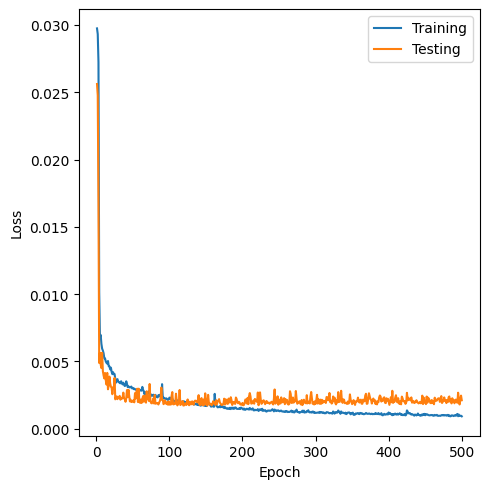

In [14]:
showTrainingLog(logs, epochs)

In [ ]:
showTrainingLog(logs, epochs, trained_epoch+1)

In [9]:
def calcR2(labels, preds): # Coefficient of Determination (R2 score)
    # ref: https://blog.csdn.net/qq_21578125/article/details/81111984 (R2_0)
    x, y = np.array(labels), np.array(preds)
    
    SSres = ((x-y)**2).sum() # residual sum of squares
    SStot = ((x-x.mean())**2).sum() # total sum of squares
    R2 = 1-SSres/SStot
    
    return R2

def calcICC(labels, preds): # Intraclass Correlation Coefficient (ICC)
    # ref: https://blog.csdn.net/qq_43426908/article/details/124365536 (ICC(1,1))
    Y = np.array([labels, preds])
    k, n = Y.shape

    df_all, df_r = n*k-1, n-1
    mean_Y = Y.mean()
    SSr = ((Y.mean(0)-mean_Y)**2).sum()*k
    SSt = ((Y-mean_Y)**2).sum()
    SSw = SSt-SSr
    
    MSr = SSr/df_r
    MSw = SSw/(df_all-df_r)
    ICC = (MSr-MSw)/(MSr+(k-1)*MSw)
    
    return ICC

def calcCMScores(labels, preds, classes): # Confusion Matrix Scores
    total_TP = 0
    scores = []

    cm = confusion_matrix(y_true=labels, y_pred=preds, labels=list(range(classes)))
    cls_num = cm.shape[0]
    all_num = np.sum(cm)

    for i in range(cls_num):
        TP = cm[i, i]
        FP = np.sum(cm[:, i])-TP
        FN = np.sum(cm[i, :])-TP
        TN = all_num-FN-FP-TP
        
        spe = TN/(TN+FP) if TN != 0 else 0 # specificity
        sen = TP/(TP+FN) if TP != 0 else 0 # sensitivity
        pre = TP/(TP+FP) if TP != 0 else 0 # precision
        F1 = 2*(sen*pre)/(sen+pre) if pre+sen != 0 else 0 # F1-score
        scores.append([spe, sen, pre, F1])
        total_TP += TP
    acc = total_TP/all_num # accuracy
    
    return cm, acc, scores

In [10]:
def startEvaluation():
    results = {}
    model.eval()

    for p, phase in enumerate(['train', 'test1', 'test2', 'test3', 'test4']):
        data_num, running_loss, running_acc = 0, 0., 0.
        all_labels, all_preds = [], []
        all_labels_class, all_preds_class = [], []

        if p == 0:
            batch_data = train_data
        elif p == 1:
            batch_data = test_data['shhs1']
        elif p == 2:
            batch_data = test_data['shhs2']
        elif p == 3:
            batch_data = test_data['apnea_ecg']
        elif p == 4:
            batch_data = test_data['耕莘dataset']

        pbar = tqdm(batch_data, unit='batch', desc=f'{phase:>5}: ')
        for b, batch in enumerate(pbar):
            signals, labels = batch
            
            with torch.no_grad():
                preds = model(signals)
                
            labels = (labels*max_AHI).flatten().tolist()
            preds = (preds*max_AHI).flatten().tolist()
            
            all_labels += [round(v, 4) for v in labels]
            all_preds += [round(v, 4) for v in preds]
            all_labels_class += [AHI_class(v) for v in labels]
            all_preds_class += [AHI_class(v) for v in preds]

        results[phase] = {'labels': all_labels, 'preds': all_preds,
                          'labels_class': all_labels_class, 'preds_class': all_preds_class}

    return results

def showResults(results, classes=4):
    for fname, result in results.items():
        metrics = []
        print(f'{fname}:')
        
        for k, v in result.items():
            labels, preds = v['labels'], v['preds']
            labels_cls, preds_cls = v['labels_class'], v['preds_class']

            R2 = calcR2(labels, preds)
            ICC = calcICC(labels, preds)
            _, Acc, _ = calcCMScores(labels_cls, preds_cls, classes)
            metrics.append([Acc, R2, ICC])
            
        df = pd.DataFrame(metrics, index=result.keys(), columns=['Acc', 'R2', 'ICC'])
        display(df.round(4))

In [16]:
def getRecordType(type_):
    if type_ == 'fixed_len':
        record_type = 'Fixed Length'
    elif type_ == 'fixed_len-2c-5':
        record_type = 'Fixed Length (2-class, AHI>=5)'
    elif type_ == 'fixed_len-2c-15':
        record_type = 'Fixed Length (2-class, AHI>=15)'
    elif type_ == 'original_len':
        record_type = 'Original Length'
    elif type_ == 'original_len-2c-5':
        record_type = 'Original Length (2-class, AHI>=5)'
    elif type_ == 'original_len-2c-15':
        record_type = 'Original Length (2-class, AHI>=15)'
        
    return record_type
    
def getRecordPhase(phase):
    if phase == 'train':
        record_phase = 'Training (MESA, MrOS)'
    elif phase == 'test1':
        record_phase = 'Testing (SHHS1)'
    elif phase == 'test2':
        record_phase = 'Testing (SHHS2)'
    elif phase == 'test3':
        record_phase = 'Testing (Apnea-ECG)'
    elif phase == 'test4':
        record_phase = 'Testing (耕莘dataset)'
    print(f'{record_phase}:')
    
    return record_phase

def getColorList(classes):
    if classes == 2:
        return ['limegreen', 'tomato']
    elif classes == 4:
        return ['limegreen', 'gold', 'orange', 'tomato']
    
def getLevelList(classes, cutoff):
    if classes == 2:
        return [cutoff]
    elif classes == 4:
        return [5, 15, 30]
    
def showScatterPlot(result_type, result, classes=4, cutoff=15):
    writer = SummaryWriter(logs_tb_dir, filename_suffix=f'-SP_{result_type}.tb')
    record_type = getRecordType(result_type)
    fontsize = 14
    linewidth = 2
    plt.rc('font', family='Times New Roman', size=fontsize)
    colors = getColorList(classes)
    levels = getLevelList(classes, cutoff)
    
    for k, v in result.items():
        record_phase = getRecordPhase(k)
        fig = plt.figure(figsize=(5, 5))
        
        labels, preds = v['labels'], v['preds']
        R2 = calcR2(labels, preds)
        print(f'R2: {R2:.4f}')

        x, y = np.array(preds), np.array(labels)
        m, b = np.polyfit(x, y, 1)
        
        groups = [[[], []] for i in range(classes)]
        for xx, yy in zip(x, y):
            groups[AHI_class(yy, classes, cutoff)][0].append(xx)
            groups[AHI_class(yy, classes, cutoff)][1].append(yy)
        for i, color in enumerate(colors):
            p1 = plt.scatter(groups[i][0], groups[i][1], c=color, marker='*') # AHI
        for level in levels:
            plt.axvline(level, color='darkgray', linestyle='--', linewidth=linewidth)
        
        p2, = plt.plot([0, max_AHI], [0, max_AHI], color='royalblue', linewidth=linewidth) # target
        x_temp = np.sort(x)
        p3, = plt.plot(x_temp, x_temp*m+b, color='black', linestyle='--', linewidth=linewidth) # regression
        
        plt.xlabel('Predicted AHI', fontweight='bold', fontsize=fontsize)
        plt.ylabel('Labeled AHI', fontweight='bold', fontsize=fontsize)
        plt.legend([p1, p2, p3], ['AHI', 'Target', 'Regression'], loc='lower right', fontsize=12, labelspacing=0)

        plt.xlim(0, max(x))
        plt.ylim(0, max(y))
        plt.tight_layout()
        plt.show()
        writer.add_figure(f'Scatter Plot ({record_type})/{record_phase}', fig)
    writer.close()
    
def showBlandAltmanPlot(result_type, result, classes=4, cutoff=15):
    # ref: https://blog.csdn.net/QKK612501/article/details/116013212
    writer = SummaryWriter(logs_tb_dir, filename_suffix=f'-BP_{result_type}.tb')
    record_type = getRecordType(result_type)
    fontsize = 14
    linewidth = 2
    plt.rc('font', family='Times New Roman', size=fontsize)
    colors = getColorList(classes)
    
    for k, v in result.items():
        record_phase = getRecordPhase(k)
        fig = plt.figure(figsize=(5, 5))
        
        labels, preds = v['labels'], v['preds']
        ICC = calcICC(labels, preds)
        print(f'ICC: {ICC:.4f}')
        
        x, y = np.array(labels), np.array(preds)
        mean = np.mean([x, y], axis=0)
        diff = x-y
        md, sd = diff.mean(), diff.std()
        ci95_p, ci95_n = md+1.96*sd, md-1.96*sd # 95% confidence interval
        
        d = len([v for v in diff if v <= ci95_p and v >= ci95_n])
        print(f'Data in 95% CI: {d}/{len(diff)} ({d/len(diff):.4f})')
        
        groups = [[[], []] for i in range(classes)]
        for i, (xx, yy) in enumerate(zip(mean, diff)):
            groups[AHI_class(x[i], classes, cutoff)][0].append(xx)
            groups[AHI_class(x[i], classes, cutoff)][1].append(yy)
        for i, color in enumerate(colors):
            p1 = plt.scatter(groups[i][0], groups[i][1], c=color, marker='*') # AHI
        
        p2 = plt.axhline(md, color='royalblue', linewidth=linewidth)
        for v in [ci95_p, ci95_n]:
            p3 = plt.axhline(v, color='black', linestyle='--', linewidth=linewidth)
        for v in [md, ci95_p, ci95_n]:
            plt.text(max(mean), v, f'{v:.2f}', fontsize=fontsize, fontweight='bold', va='bottom', ha='right')

        plt.xlabel('Mean of labeled and predicted AHI', fontweight='bold', fontsize=fontsize)
        plt.ylabel('Labeled - predicted AHI', fontweight='bold', fontsize=fontsize)
        plt.legend([p1, p2, p3], ['AHI', 'Mean', '±1.96 SD'], loc='upper left', fontsize=12, labelspacing=0)

        plt.xlim(0, max(mean))
        plt.tight_layout()
        plt.show()
        writer.add_figure(f'Bland-Altman Plot ({record_type})/{record_phase}', fig)
    writer.close()

def showConfusionMatrix(result_type, result, classes=4):
    writer = SummaryWriter(logs_tb_dir, filename_suffix=f'-CM_{result_type}.tb')
    record_type = getRecordType(result_type)
    fontsize = 14
    plt.rc('font', family='Times New Roman', size=fontsize)
    
    for k, v in result.items():
        record_phase = getRecordPhase(k)
        fig = plt.figure(figsize=(5, 5))
        
        labels, preds = v['labels_class'], v['preds_class']
        cm, acc, scores = calcCMScores(labels, preds, classes)
        print(f'Accuracy: {acc:.4f}')
        
        df = pd.DataFrame(scores, index=range(classes), columns=['Spe', 'Sen', 'Pre', 'F1'])
        df.loc['Mean'] = df.mean(axis=0)
        display(df.round(4))

        new_cm = np.array([(r/sum(r)*100) if sum(r) != 0 else np.zeros(classes) for r in cm])
        new_cm = [[f'{c1}\n({c2:.2f}%)' for c1, c2 in zip(r1, r2)] for r1, r2 in zip(cm, new_cm)]
        ax = sn.heatmap(cm, annot=new_cm, annot_kws={'size': fontsize}, cmap='Blues', cbar=False, fmt='',
                        linewidths=.5, linecolor='black', clip_on=False)

        ax.set_xlabel('Predicted', fontweight='bold', fontsize=fontsize)
        ax.set_ylabel('Labeled', fontweight='bold', fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
        plt.tight_layout()
        plt.show()
        writer.add_figure(f'Confusion Matrix ({record_type})/{record_phase}', fig)
    writer.close()

In [12]:
class EvaluationDataset(Dataset):
    def __init__(self, data_type, signal, label):
        self.data_type = data_type
        self.signal = signal
        self.label = label
        
    def __getitem__(self, index):
        if self.data_type == 'fixed': # fixed length
            signal = torch.tensor(cut_pad_signal(self.signal[index]), dtype=torch.float32).cuda().unsqueeze(0)
        elif self.data_type == 'original': # original length
            signal = torch.tensor(self.signal[index], dtype=torch.float32).cuda().unsqueeze(0)
        label = torch.tensor(self.label[index], dtype=torch.float32).cuda().unsqueeze(0)
        return signal, label
    
    def __len__(self):
        return len(self.signal)

In [13]:
# fixed length results
batch_size = 128
train_data = DataLoader(EvaluationDataset('fixed', train_info['signal'], train_info['label']),
                        batch_size=batch_size)
test_data = {}
for k in test_list.keys():
    test_data[k] = DataLoader(EvaluationDataset('fixed', test_info[k]['signal'], test_info[k]['label']),
                              batch_size=batch_size)

In [14]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname] = startEvaluation()

with open(results_dir/'fixed_length.json', 'w') as f:
     json.dump(results, f)

best_loss:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.12batch/s]


epoch_100:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.04batch/s]


epoch_200:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.62batch/s]


epoch_300:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.09batch/s]


epoch_400:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.84batch/s]


epoch_500:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.27batch/s]


In [13]:
# for reload results
with open(results_dir/'fixed_length.json', 'r') as f:
     results = json.load(f)

In [14]:
showResults(results)

best_loss:


,Acc,R2,ICC
train,0.8235,0.9451,0.9716
test1,0.8029,0.9277,0.9619
test2,0.7748,0.8995,0.9475
test3,0.8750,0.9120,0.9631
test4,0.8319,0.8536,0.9197


epoch_100:


,Acc,R2,ICC
train,0.8081,0.9277,0.9607
test1,0.8013,0.9247,0.9588
test2,0.7627,0.8999,0.9454
test3,0.7500,0.8975,0.9589
test4,0.8145,0.8469,0.9149


epoch_200:


,Acc,R2,ICC
train,0.8365,0.9525,0.9746
test1,0.7953,0.9194,0.9563
test2,0.7857,0.8994,0.9456
test3,0.8750,0.9247,0.9670
test4,0.8029,0.8331,0.9062


epoch_300:


,Acc,R2,ICC
train,0.8535,0.9619,0.9802
test1,0.8068,0.9225,0.9589
test2,0.7854,0.9042,0.9496
test3,0.8750,0.8994,0.9578
test4,0.8203,0.8543,0.9215


epoch_400:


,Acc,R2,ICC
train,0.8607,0.9630,0.9802
test1,0.7916,0.9163,0.9543
test2,0.7940,0.9046,0.9478
test3,0.8750,0.9352,0.9725
test4,0.8232,0.8410,0.9105


epoch_500:


,Acc,R2,ICC
train,0.8677,0.9698,0.9842
test1,0.7849,0.9109,0.9522
test2,0.7865,0.9040,0.9485
test3,0.8750,0.8498,0.9371
test4,0.8087,0.8380,0.9122


In [15]:
# choose best result
chosen_result = results['epoch_300']

Training (MESA, MrOS):
R2: 0.9619


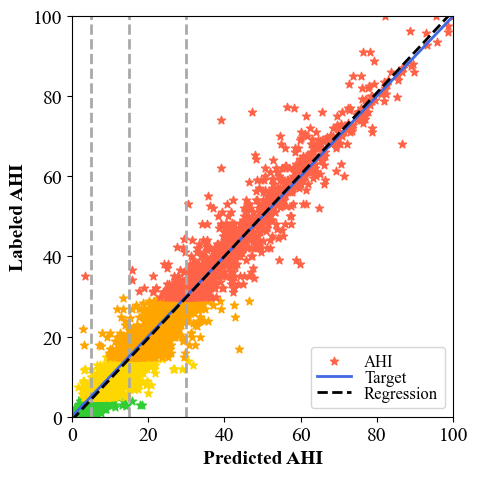

Testing (SHHS1):
R2: 0.9225


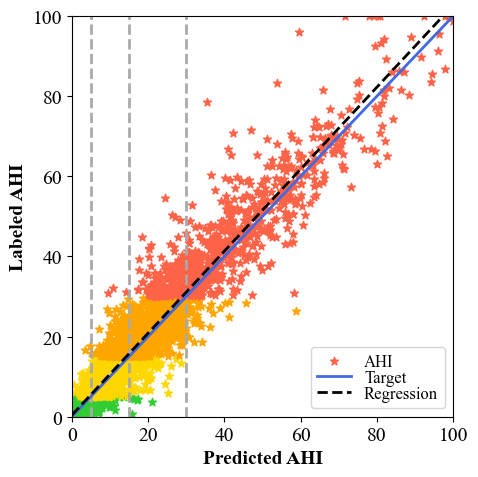

Testing (SHHS2):
R2: 0.9042


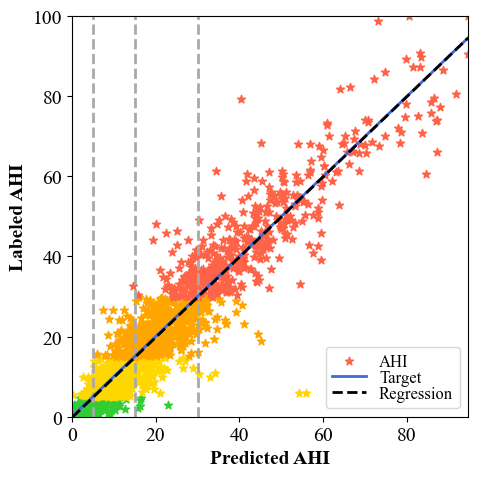

Testing (Apnea-ECG):
R2: 0.8994


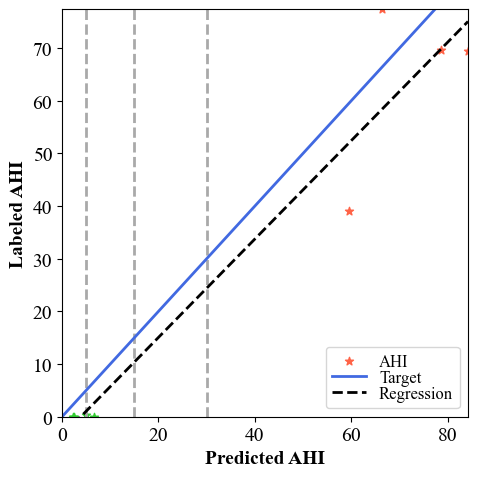

Testing (耕莘dataset):
R2: 0.8543


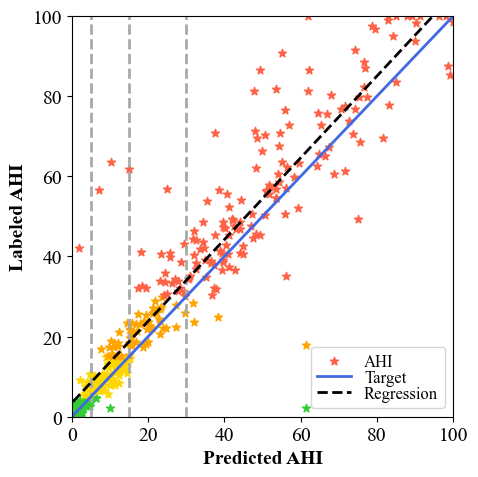

In [17]:
# Scatter Plot
showScatterPlot('fixed_len', chosen_result)

Training (MESA, MrOS):
ICC: 0.9802
Data in 95% CI: 5659/5988 (0.9451)


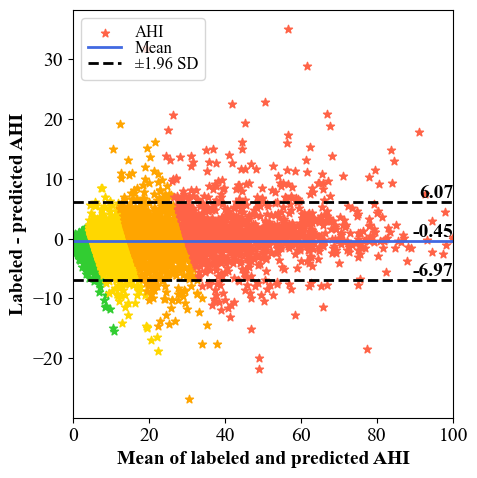

Testing (SHHS1):
ICC: 0.9589
Data in 95% CI: 5446/5793 (0.9401)


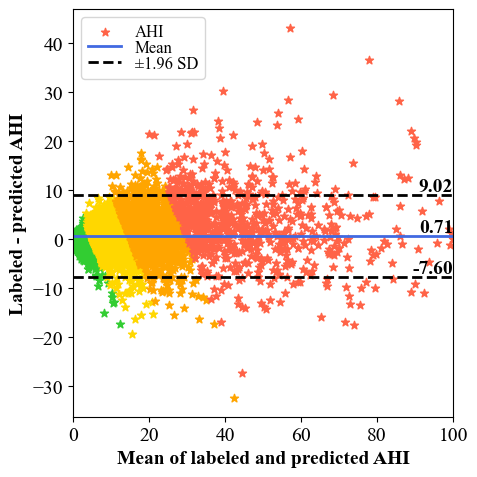

Testing (SHHS2):
ICC: 0.9496
Data in 95% CI: 2501/2651 (0.9434)


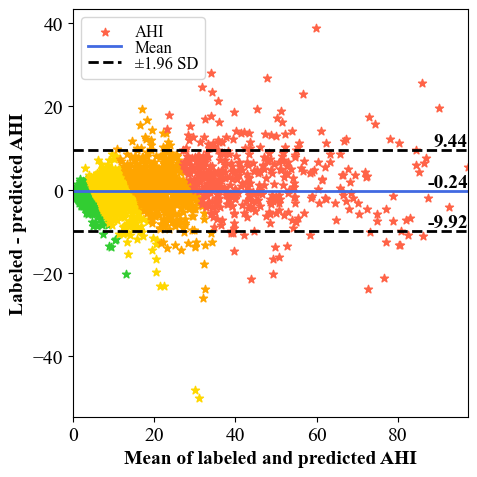

Testing (Apnea-ECG):
ICC: 0.9578
Data in 95% CI: 7/8 (0.8750)


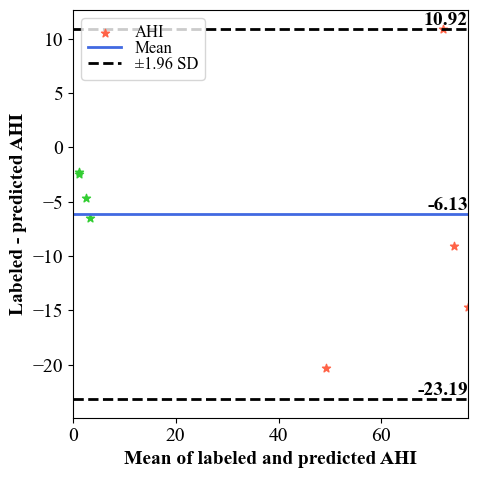

Testing (耕莘dataset):
ICC: 0.9215
Data in 95% CI: 329/345 (0.9536)


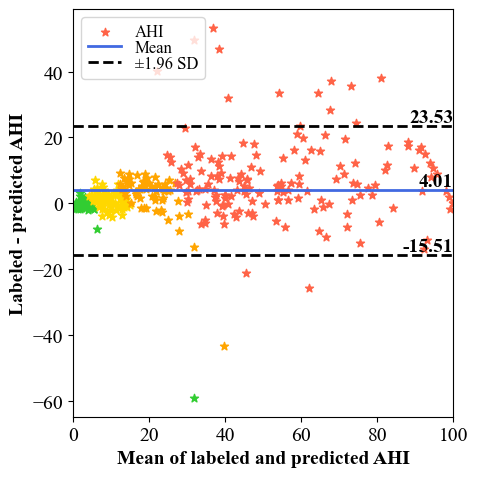

In [26]:
# Bland-Altman Plot
showBlandAltmanPlot('fixed_len', chosen_result)

Training (MESA, MrOS):
Accuracy: 0.8535


,Spe,Sen,Pre,F1
0,0.9813,0.7579,0.8981,0.8221
1,0.9002,0.8593,0.8155,0.8368
2,0.9301,0.8606,0.8170,0.8383
3,0.9823,0.9149,0.9344,0.9246
Mean,0.9485,0.8482,0.8663,0.8554


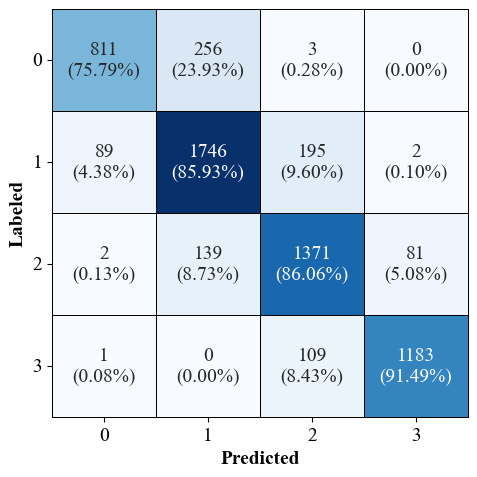

Testing (SHHS1):
Accuracy: 0.8068


,Spe,Sen,Pre,F1
0,0.9414,0.8579,0.8652,0.8615
1,0.8573,0.8223,0.7567,0.7881
2,0.9346,0.7251,0.7506,0.7377
3,0.9905,0.7800,0.9250,0.8463
Mean,0.9309,0.7963,0.8244,0.8084


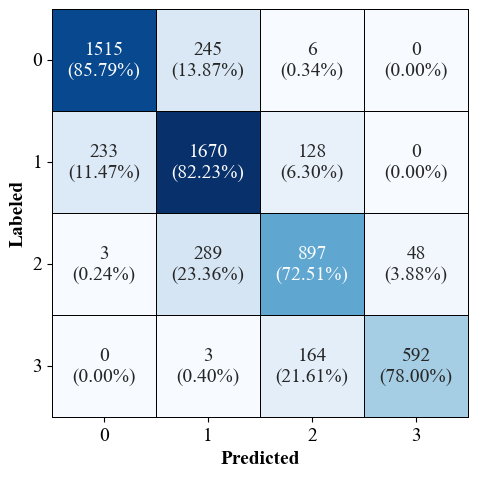

Testing (SHHS2):
Accuracy: 0.7854


,Spe,Sen,Pre,F1
0,0.9763,0.7313,0.9055,0.8091
1,0.8344,0.8250,0.7388,0.7795
2,0.9057,0.7473,0.7147,0.7306
3,0.9771,0.8329,0.8741,0.8530
Mean,0.9234,0.7841,0.8083,0.7931


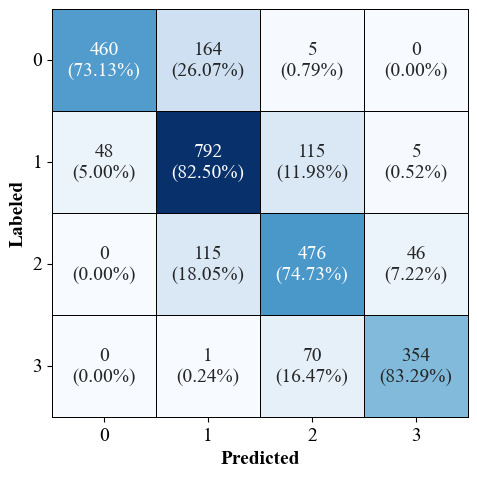

Testing (Apnea-ECG):
Accuracy: 0.8750


,Spe,Sen,Pre,F1
0,1.0000,0.7500,1.0,0.8571
1,0.8750,0.0000,0.0,0.0000
2,1.0000,0.0000,0.0,0.0000
3,1.0000,1.0000,1.0,1.0000
Mean,0.9688,0.4375,0.5,0.4643


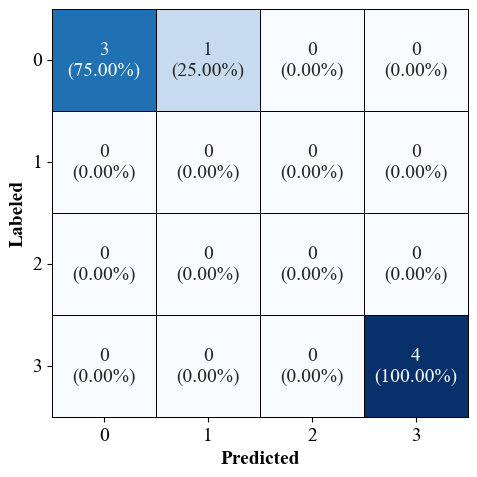

Testing (耕莘dataset):
Accuracy: 0.8203


,Spe,Sen,Pre,F1
0,0.9600,0.8889,0.7692,0.8247
1,0.9216,0.8442,0.7558,0.7975
2,0.9155,0.6885,0.6364,0.6614
3,0.9727,0.8395,0.9645,0.8977
Mean,0.9425,0.8153,0.7815,0.7953


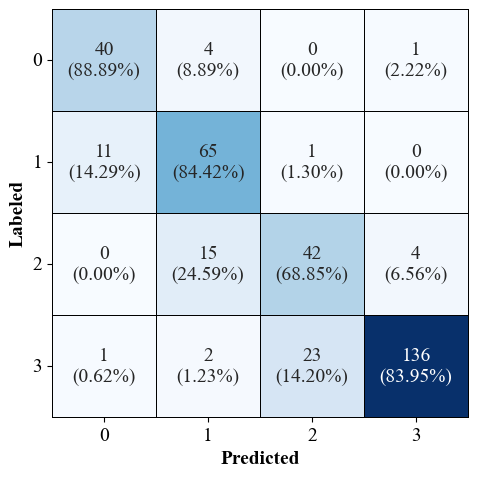

In [18]:
# Confusion Matrix
showConfusionMatrix('fixed_len', chosen_result)

In [20]:
# original length results
batch_size = 1
train_data = DataLoader(EvaluationDataset('original', train_info['signal'], train_info['label']),
                        batch_size=batch_size)
test_data = {}
for k in test_list.keys():
    test_data[k] = DataLoader(EvaluationDataset('original', test_info[k]['signal'], test_info[k]['label']),
                              batch_size=batch_size)

In [21]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname] = startEvaluation()

with open(results_dir/'original_length.json', 'w') as f:
     json.dump(results, f)

best_loss:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 137.97batch/s]


epoch_100:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 164.40batch/s]


epoch_200:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 169.41batch/s]


epoch_300:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:01<00:00, 206.97batch/s]


epoch_400:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:01<00:00, 207.94batch/s]


epoch_500:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:01<00:00, 210.73batch/s]


In [19]:
# for reload results
with open(results_dir/'original_length.json', 'r') as f:
     results = json.load(f)

In [20]:
showResults(results)

best_loss:


,Acc,R2,ICC
train,0.8270,0.9439,0.9707
test1,0.8070,0.9305,0.9633
test2,0.7857,0.9025,0.9488
test3,0.7500,0.9237,0.9671
test4,0.8319,0.8565,0.9206


epoch_100:


,Acc,R2,ICC
train,0.8103,0.9281,0.9606
test1,0.8008,0.9267,0.9597
test2,0.7642,0.9023,0.9463
test3,0.8750,0.9148,0.9647
test4,0.8261,0.8486,0.9152


epoch_200:


,Acc,R2,ICC
train,0.8367,0.9519,0.9741
test1,0.8053,0.9244,0.9588
test2,0.7971,0.9036,0.9473
test3,0.7500,0.9489,0.9771
test4,0.8319,0.8372,0.9076


epoch_300:


,Acc,R2,ICC
train,0.8529,0.9602,0.9790
test1,0.8113,0.9272,0.9611
test2,0.7925,0.9092,0.9516
test3,0.7500,0.9305,0.9707
test4,0.8232,0.8568,0.9223


epoch_400:


,Acc,R2,ICC
train,0.8612,0.9596,0.9780
test1,0.8044,0.9199,0.9561
test2,0.7963,0.9063,0.9482
test3,0.8750,0.9324,0.9698
test4,0.8232,0.8444,0.9120


epoch_500:


,Acc,R2,ICC
train,0.8671,0.9654,0.9816
test1,0.7989,0.9176,0.9556
test2,0.7993,0.9091,0.9509
test3,1.0000,0.8903,0.9554
test4,0.8261,0.8441,0.9154


In [21]:
# choose best result
chosen_result = results['epoch_300']

Training (MESA, MrOS):
R2: 0.9602


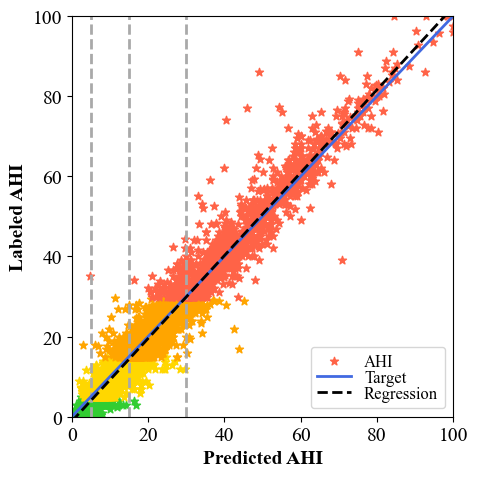

Testing (SHHS1):
R2: 0.9272


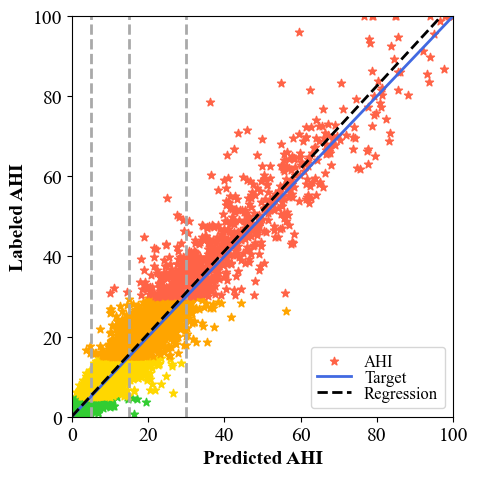

Testing (SHHS2):
R2: 0.9092


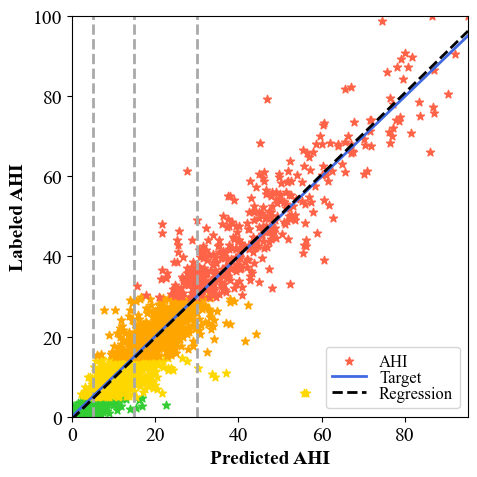

Testing (Apnea-ECG):
R2: 0.9305


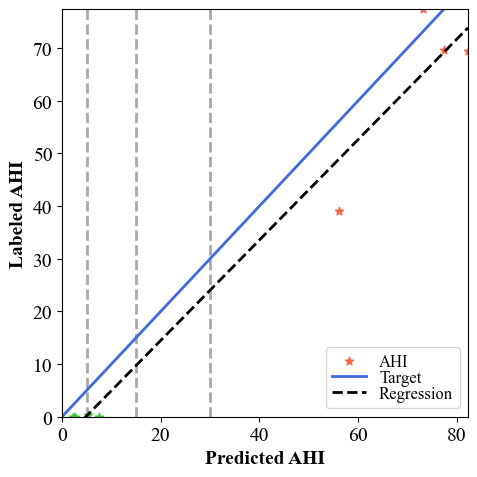

Testing (耕莘dataset):
R2: 0.8568


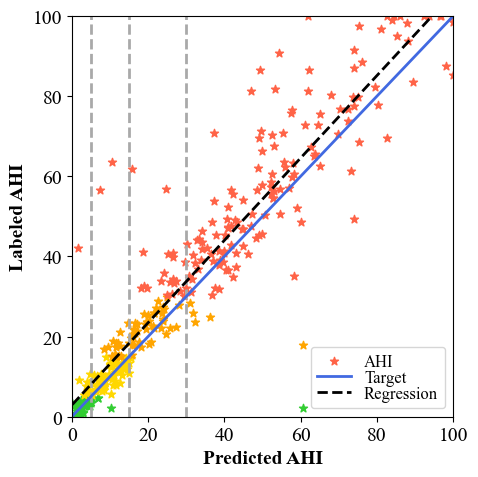

In [22]:
# Scatter Plot
showScatterPlot('original_len', chosen_result)

Training (MESA, MrOS):
ICC: 0.9790
Data in 95% CI: 5672/5988 (0.9472)


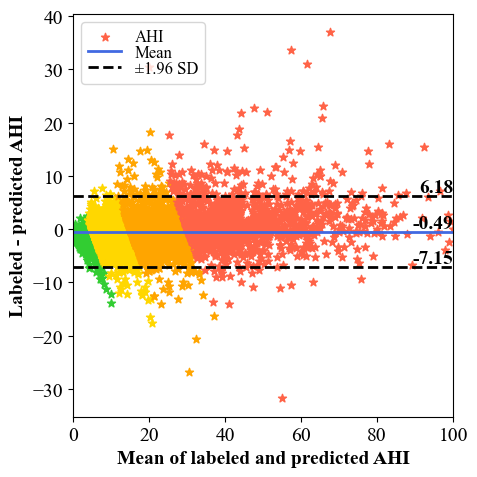

Testing (SHHS1):
ICC: 0.9611
Data in 95% CI: 5453/5793 (0.9413)


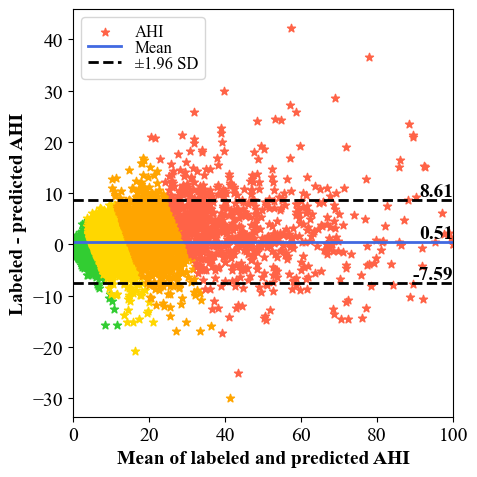

Testing (SHHS2):
ICC: 0.9516
Data in 95% CI: 2503/2651 (0.9442)


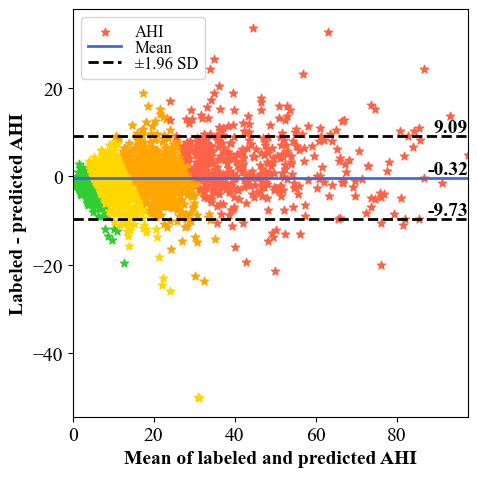

Testing (Apnea-ECG):
ICC: 0.9707
Data in 95% CI: 8/8 (1.0000)


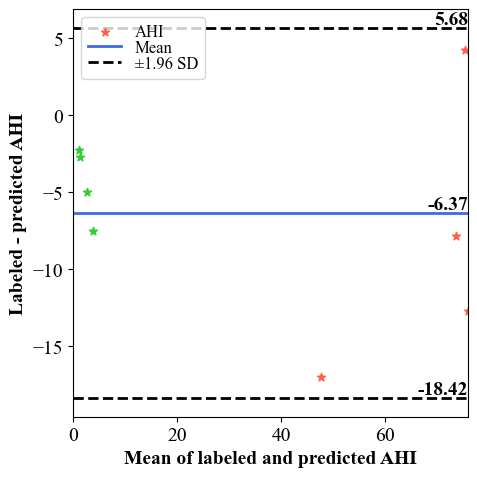

Testing (耕莘dataset):
ICC: 0.9223
Data in 95% CI: 329/345 (0.9536)


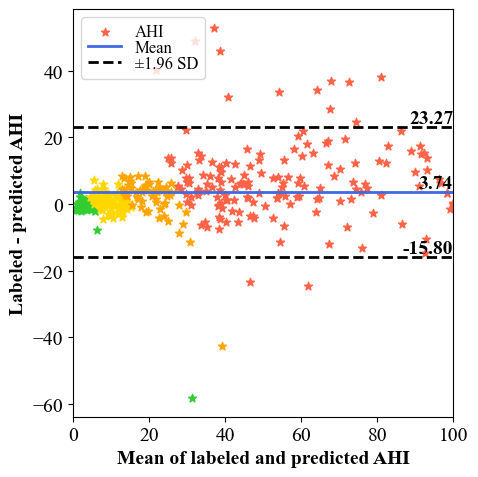

In [30]:
# Bland-Altman Plot
showBlandAltmanPlot('original_len', chosen_result)

Training (MESA, MrOS):
Accuracy: 0.8529


,Spe,Sen,Pre,F1
0,0.9831,0.7402,0.9051,0.8144
1,0.8994,0.8647,0.8153,0.8393
2,0.9290,0.8675,0.8158,0.8409
3,0.9813,0.9095,0.9304,0.9198
Mean,0.9482,0.8455,0.8667,0.8536


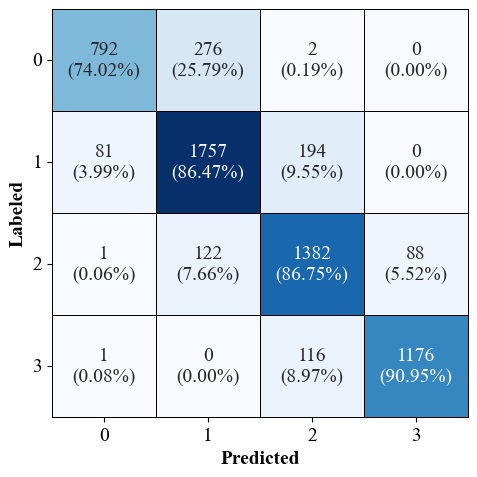

Testing (SHHS1):
Accuracy: 0.8113


,Spe,Sen,Pre,F1
0,0.9513,0.8448,0.8839,0.8639
1,0.8581,0.8331,0.7601,0.7949
2,0.9320,0.7437,0.7480,0.7458
3,0.9895,0.7852,0.9183,0.8466
Mean,0.9327,0.8017,0.8276,0.8128


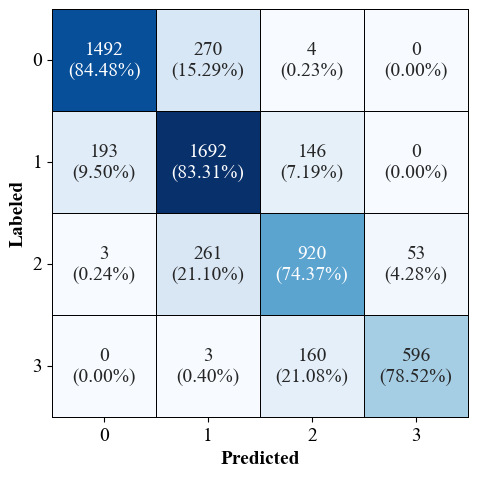

Testing (SHHS2):
Accuracy: 0.7925


,Spe,Sen,Pre,F1
0,0.9777,0.7059,0.9080,0.7943
1,0.8380,0.8302,0.7442,0.7848
2,0.9086,0.7881,0.7318,0.7589
3,0.9789,0.8424,0.8840,0.8627
Mean,0.9258,0.7916,0.8170,0.8002


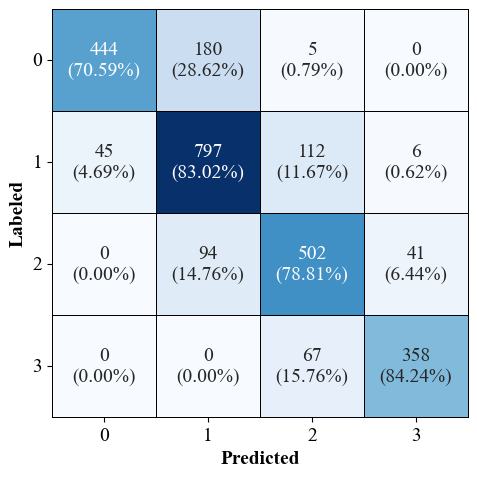

Testing (Apnea-ECG):
Accuracy: 0.7500


,Spe,Sen,Pre,F1
0,1.0000,0.500,1.0,0.6667
1,0.7500,0.000,0.0,0.0000
2,1.0000,0.000,0.0,0.0000
3,1.0000,1.000,1.0,1.0000
Mean,0.9375,0.375,0.5,0.4167


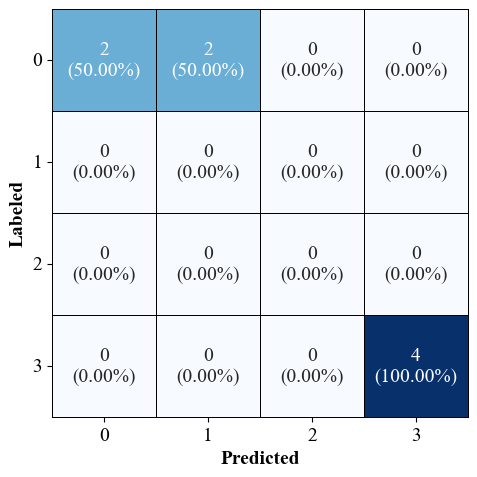

Testing (耕莘dataset):
Accuracy: 0.8232


,Spe,Sen,Pre,F1
0,0.9633,0.8667,0.7800,0.8211
1,0.9179,0.8442,0.7471,0.7927
2,0.9225,0.6721,0.6508,0.6613
3,0.9672,0.8580,0.9586,0.9055
Mean,0.9427,0.8102,0.7841,0.7951


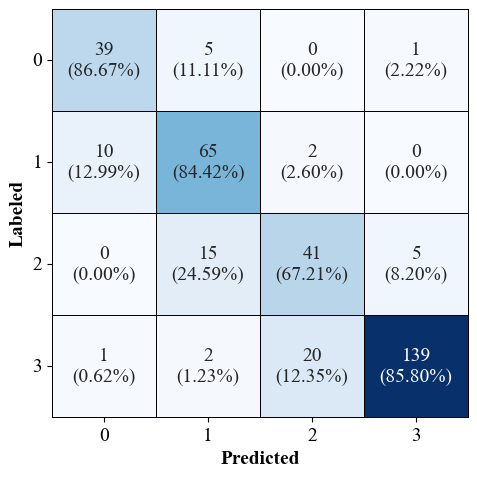

In [23]:
# Confusion Matrix
showConfusionMatrix('original_len', chosen_result)

Training (MESA, MrOS):
Accuracy: 0.9397


,Spe,Sen,Pre,F1
0,0.9831,0.7402,0.9051,0.8144
1,0.7402,0.9831,0.9456,0.9640
Mean,0.8617,0.8617,0.9254,0.8892


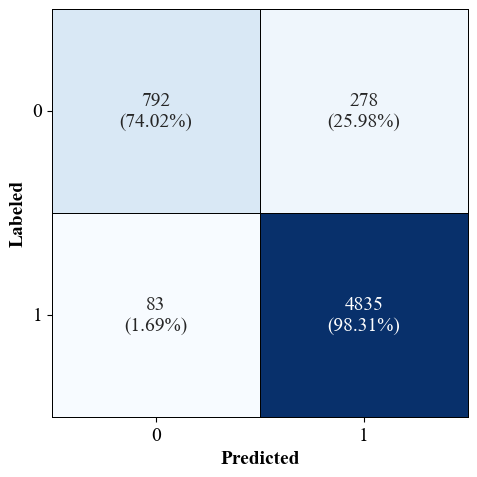

Testing (SHHS1):
Accuracy: 0.9189


,Spe,Sen,Pre,F1
0,0.9513,0.8448,0.8839,0.8639
1,0.8448,0.9513,0.9333,0.9422
Mean,0.8981,0.8981,0.9086,0.9031


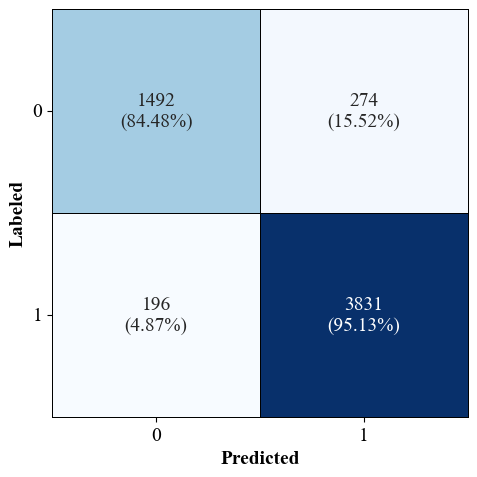

Testing (SHHS2):
Accuracy: 0.9132


,Spe,Sen,Pre,F1
0,0.9777,0.7059,0.9080,0.7943
1,0.7059,0.9777,0.9144,0.9450
Mean,0.8418,0.8418,0.9112,0.8697


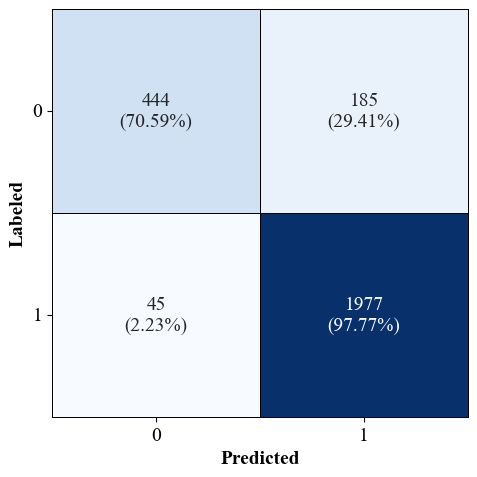

Testing (Apnea-ECG):
Accuracy: 0.7500


,Spe,Sen,Pre,F1
0,1.00,0.50,1.0000,0.6667
1,0.50,1.00,0.6667,0.8000
Mean,0.75,0.75,0.8333,0.7333


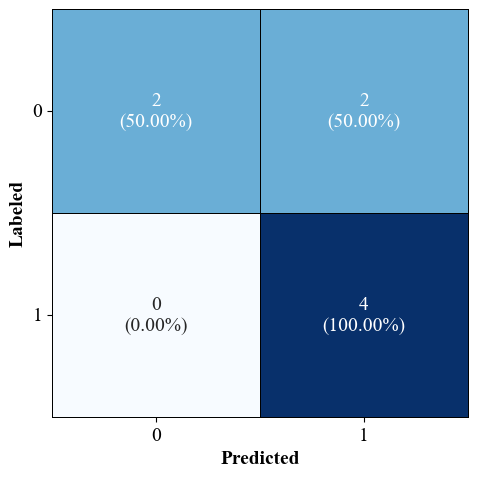

Testing (耕莘dataset):
Accuracy: 0.9507


,Spe,Sen,Pre,F1
0,0.9633,0.8667,0.7800,0.8211
1,0.8667,0.9633,0.9797,0.9714
Mean,0.9150,0.9150,0.8798,0.8962


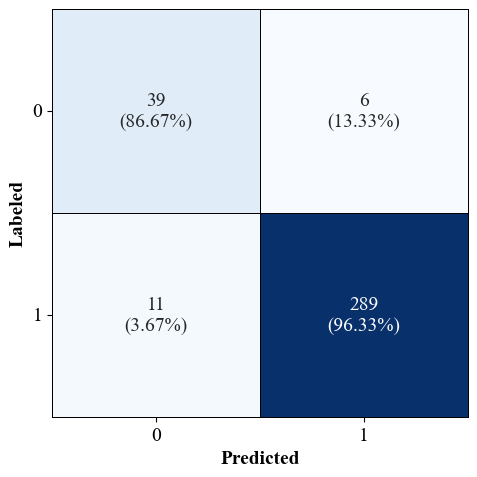

In [24]:
# Confusion Matrix (2-class, AHI>=5)
chosen_result_2c = {k: {} for k in chosen_result.keys()}
for k, v in chosen_result.items():
    for kk in ['labels_class', 'preds_class']:
        chosen_result_2c[k][kk] = [1 if vv >= 1 else 0 for vv in v[kk]]
showConfusionMatrix('original_len-2c-5', chosen_result_2c, 2)

Training (MESA, MrOS):
Accuracy: 0.9466


,Spe,Sen,Pre,F1
0,0.9570,0.9368,0.9591,0.9478
1,0.9368,0.9570,0.9337,0.9452
Mean,0.9469,0.9469,0.9464,0.9465


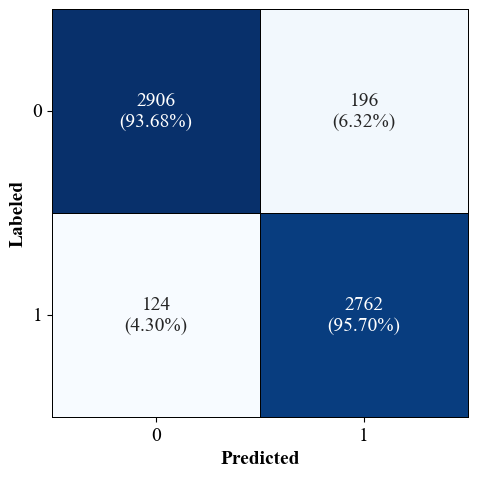

Testing (SHHS1):
Accuracy: 0.9280


,Spe,Sen,Pre,F1
0,0.8662,0.9605,0.9318,0.9459
1,0.9605,0.8662,0.9202,0.8924
Mean,0.9134,0.9134,0.9260,0.9192


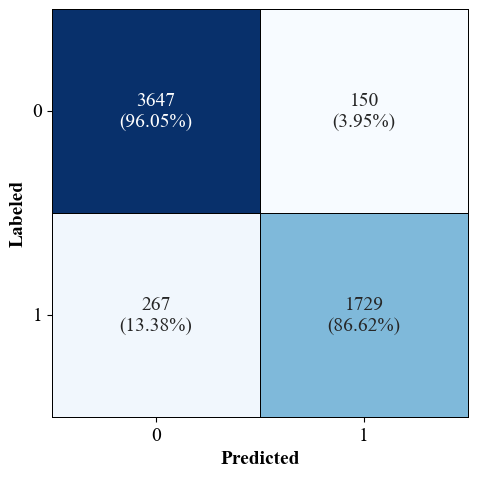

Testing (SHHS2):
Accuracy: 0.9181


,Spe,Sen,Pre,F1
0,0.9115,0.9226,0.9397,0.9311
1,0.9226,0.9115,0.8873,0.8992
Mean,0.9170,0.9170,0.9135,0.9151


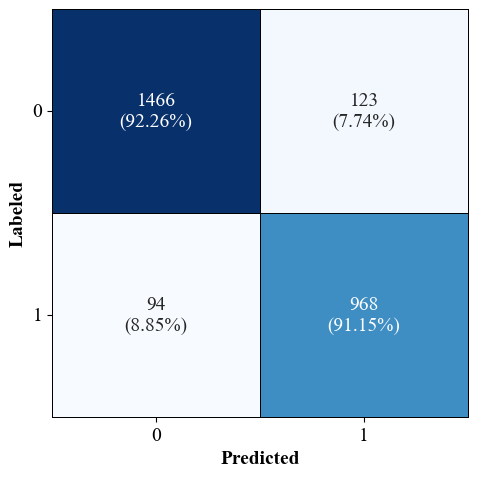

Testing (Apnea-ECG):
Accuracy: 1.0000


,Spe,Sen,Pre,F1
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
Mean,1.0,1.0,1.0,1.0


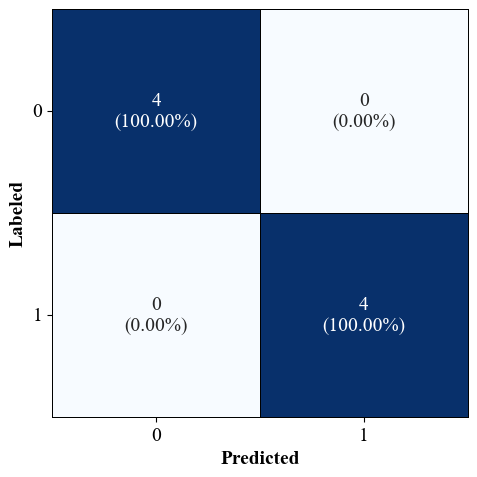

Testing (耕莘dataset):
Accuracy: 0.9391


,Spe,Sen,Pre,F1
0,0.9193,0.9754,0.8686,0.9189
1,0.9754,0.9193,0.9856,0.9513
Mean,0.9473,0.9473,0.9271,0.9351


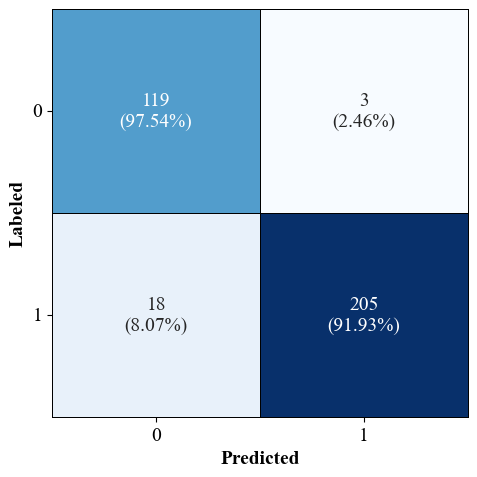

In [25]:
# Confusion Matrix (2-class, AHI>=15)
chosen_result_2c = {k: {} for k in chosen_result.keys()}
for k, v in chosen_result.items():
    for kk in ['labels_class', 'preds_class']:
        chosen_result_2c[k][kk] = [1 if vv >= 2 else 0 for vv in v[kk]]
showConfusionMatrix('original_len-2c-15', chosen_result_2c, 2)